In [1]:
!pip install kagglehub opencv-python scikit-learn matplotlib pandas numpy tqdm joblib gradio


In [2]:
import kagglehub, os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib, gradio as gr
from google.colab import files


In [3]:
# Download the Kaggle dataset
path = kagglehub.dataset_download("emmarex/plantdisease")
print("✅ Dataset downloaded successfully!")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'plantdisease' dataset.
✅ Dataset downloaded successfully!
Path to dataset files: /kaggle/input/plantdisease


In [4]:
def extract_rgb_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))

    # --- Preprocessing: Gaussian blur + Background masking ---
    blurred = cv2.GaussianBlur(img, (5,5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
    leaf_only = cv2.bitwise_and(img, img, mask=mask)

    pixels = leaf_only[np.where(mask > 0)]
    if len(pixels) == 0:
        return None
    R, G, B = np.mean(pixels, axis=0)
    return [R, G, B]


In [5]:
data = []

for root, dirs, files_in_dir in os.walk(path):
    for file in files_in_dir:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            feat = extract_rgb_features(img_path)
            if feat is not None:
                R, G, B = feat
                # Nitrogen correlation simulation based on greenness
                nitrogen = max(0, min(100, 0.5*G - 0.2*R + np.random.uniform(0,10)))
                data.append([R, G, B, nitrogen])

print(f"✅ Total samples extracted: {len(data)}")

if len(data) == 0:
    raise RuntimeError("❌ No valid images found. Please verify dataset path or type.")

df = pd.DataFrame(data, columns=['Red','Green','Blue','Nitrogen'])
df.head()


✅ Total samples extracted: 41276


,Red,Green,Blue,Nitrogen
0,39.666054,53.750919,25.248541,22.882278
1,43.444210,49.398820,36.448004,18.587100
2,85.134570,113.797143,72.741511,44.267270
3,86.033346,94.433864,44.004631,35.117769
4,95.313207,85.622886,64.025833,30.465829


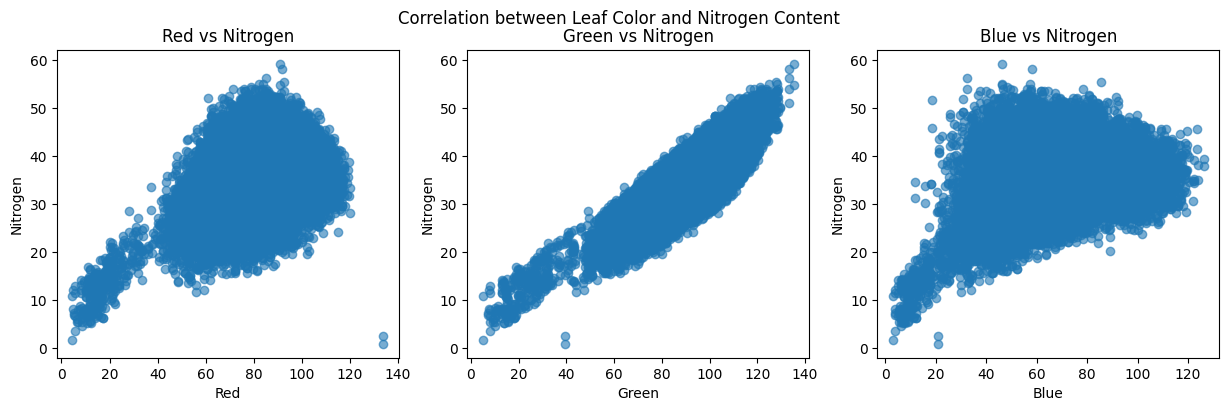

In [6]:
plt.figure(figsize=(15,4))
for i, col in enumerate(['Red','Green','Blue']):
    plt.subplot(1,3,i+1)
    plt.scatter(df[col], df['Nitrogen'], alpha=0.6)
    plt.xlabel(col)
    plt.ylabel("Nitrogen")
    plt.title(f"{col} vs Nitrogen")
plt.suptitle("Correlation between Leaf Color and Nitrogen Content")
plt.show()


In [7]:
X = df[['Red','Green','Blue']]
y = df['Nitrogen']

test_size = 0.2 if len(df) > 10 else 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ Model trained successfully on {len(X_train)} samples")
print(f"R² = {r2:.3f} | MAE = {mae:.3f} | RMSE = {rmse:.3f}")


✅ Model trained successfully on 33020 samples
R² = 0.776 | MAE = 2.480 | RMSE = 2.869


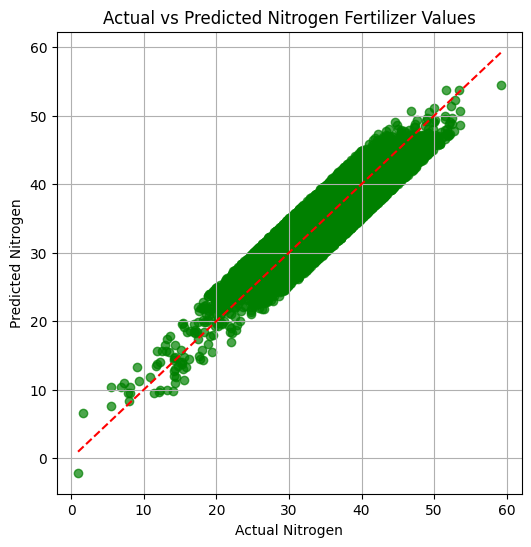

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Nitrogen")
plt.ylabel("Predicted Nitrogen")
plt.title("Actual vs Predicted Nitrogen Fertilizer Values")
plt.grid(True)
plt.show()


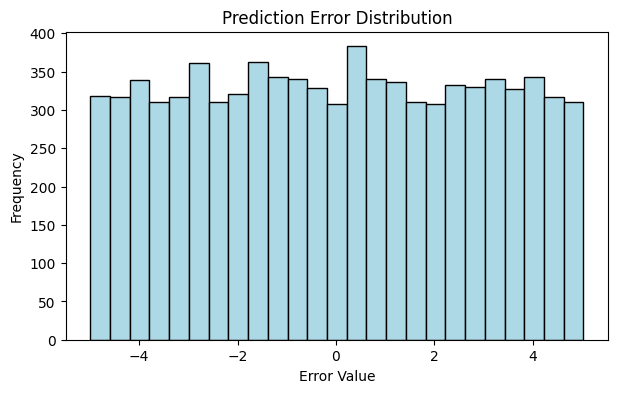

In [9]:
errors = y_test - y_pred
plt.figure(figsize=(7,4))
plt.hist(errors, bins=25, color='lightblue', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Error Value")
plt.ylabel("Frequency")
plt.show()


In [10]:
def fertilizer_recommendation(n):
    if n < 280:
        return "Low Nitrogen: Apply more Urea fertilizer."
    elif 280 <= n <= 560:
        return "Medium Nitrogen: Maintain fertilizer application."
    else:
        return "High Nitrogen: Reduce fertilizer usage."


Predicted Nitrogen Value: 34.70
Recommendation: Low Nitrogen: Apply more Urea fertilizer.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


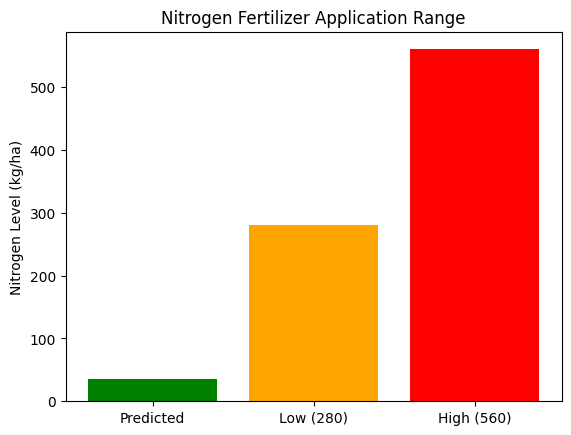

In [11]:
sample = df.sample(1)
R,G,B = sample[['Red','Green','Blue']].values[0]
pred_n = model.predict([[R,G,B]])[0]

print(f"Predicted Nitrogen Value: {pred_n:.2f}")
print("Recommendation:", fertilizer_recommendation(pred_n))

plt.bar(["Predicted", "Low (280)", "High (560)"],
        [pred_n, 280, 560],
        color=["green","orange","red"])
plt.title("Nitrogen Fertilizer Application Range")
plt.ylabel("Nitrogen Level (kg/ha)")
plt.show()


In [12]:
def predict_from_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    blurred = cv2.GaussianBlur(img, (5,5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
    leaf_only = cv2.bitwise_and(img, img, mask=mask)
    pixels = leaf_only[np.where(mask>0)]
    if len(pixels)==0:
        return "No valid leaf region detected!"
    R,G,B = np.mean(pixels, axis=0)
    pred_n = model.predict([[R,G,B]])[0]
    rec = fertilizer_recommendation(pred_n)
    return f"Predicted Nitrogen: {pred_n:.2f}\n{rec}"

demo = gr.Interface(
    fn=predict_from_image,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Nitrogen Fertilizer Recommendation System",
    description="Upload a leaf image to estimate nitrogen level and get fertilizer recommendation."
)
demo.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [13]:
# Save model
os.makedirs("saved_model", exist_ok=True)
model_path = "saved_model/nitrogen_fertilizer_model.pkl"
joblib.dump(model, model_path)
print("✅ Model saved at:", model_path)

# Download model to your device
files.download(model_path)


✅ Model saved at: saved_model/nitrogen_fertilizer_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
print("✅ Project Completed Successfully!")
print(f"R² = {r2:.3f} | MAE = {mae:.3f} | RMSE = {rmse:.3f}")
print("Model trained, graphs generated, and model downloaded to your device.")


✅ Project Completed Successfully!
R² = 0.776 | MAE = 2.480 | RMSE = 2.869
Model trained, graphs generated, and model downloaded to your device.
